In [36]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
import haversine as hs
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from faker import Faker

pio.renderers.default = "notebook"

## Suppress scientific notation
pd.options.display.float_format = '{:.4f}'.format

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./dataset.csv')
df.head()

,DriverId,EventName,Latitude,Longitude,Speed km/h,ts
0,0,Timed Event,34.1866,-118.0881,64.0000,2017-11-01 00:00:02.430
1,0,Distance Event,34.1861,-118.0892,53.0000,2017-11-01 00:00:05.600
2,0,Distance Event,34.1864,-118.0896,34.0000,2017-11-01 00:00:13.640
3,0,Distance Event,34.1875,-118.0889,33.0000,2017-11-01 00:00:26.070
4,0,Distance Event,34.1887,-118.0865,32.0000,2017-11-01 00:00:35.090


In [3]:
df['ts'] = pd.to_datetime(df['ts'])
df.head()

,DriverId,EventName,Latitude,Longitude,Speed km/h,ts
0,0,Timed Event,34.1866,-118.0881,64.0000,2017-11-01 00:00:02.430
1,0,Distance Event,34.1861,-118.0892,53.0000,2017-11-01 00:00:05.600
2,0,Distance Event,34.1864,-118.0896,34.0000,2017-11-01 00:00:13.640
3,0,Distance Event,34.1875,-118.0889,33.0000,2017-11-01 00:00:26.070
4,0,Distance Event,34.1887,-118.0865,32.0000,2017-11-01 00:00:35.090


In [22]:
eventsPerDriver = df.groupby('DriverId').agg({"EventName":"count"}).add_suffix('_count')
averageNoEvents = np.mean(eventsPerDriver).values[0].round(1)
averageNoEvents

10108.0

In [24]:
eventsPerDriver.sort_values(by='EventName_count', ascending=False, inplace=True)
eventsPerDriver.head()

,EventName_count
DriverId,
49,31942
77,30420
45,30319
51,26917
5,24152


In [25]:
dfReasonHist = df.groupby(['EventName'])[['EventName']].agg('count').add_suffix('_Count').reset_index().sort_values('EventName_Count',ascending=True)
dfReasonHist.head()

,EventName,EventName_Count
8,Harsh Turn Left (motion based),805
4,Harsh Acceleration (motion based),808
9,Harsh Turn Right (motion based),853
6,Harsh Braking (motion based),1838
7,Harsh Turn (motion based),2298


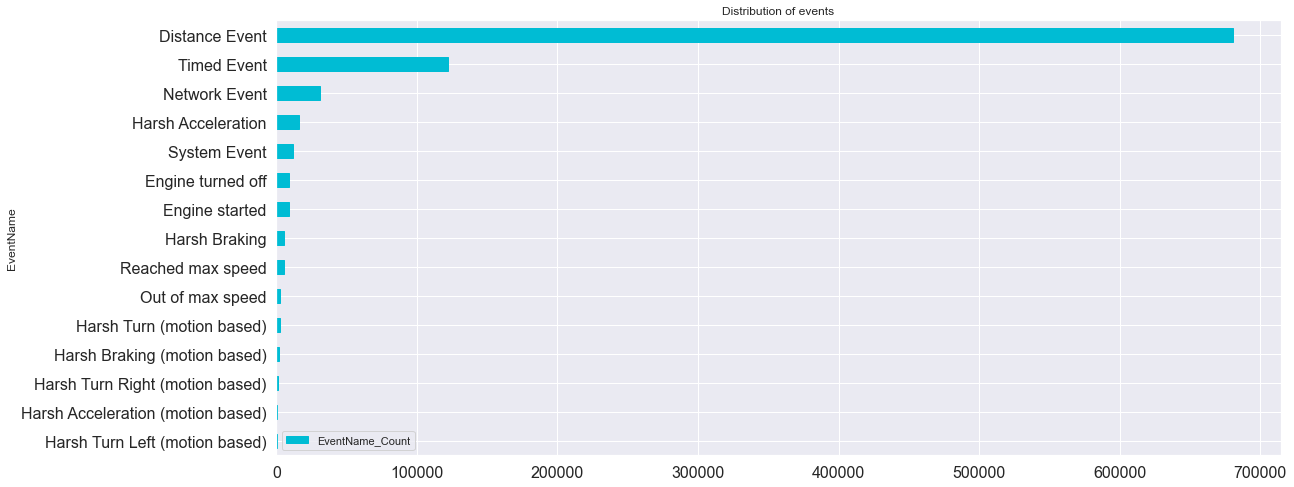

In [37]:
dfReasonHist.plot.barh('EventName','EventName_Count',figsize=(18,8),fontsize = 16, color = '#00bcd4', edgecolor = '#00bcd4', title = 'Distribution of events')

plt.legend()
plt.show()

Remov